In [1]:
import math
import h3pandas
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import split
from shapely.geometry import LineString
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

# Формирование сетки шестиугольников

Формирование сетки шестиугольников в рамках заданного населённого пункта для
расчётов необходимых в рамках данного проекта, в том числе плотности
населения.

Сетка формируется с помощью алгоритма приведённого ниже. К сожалению в нашем
случае нет возможности использовать библиотеку `h3geopandas`, так как
архитектура данной библиотеки не даёт возможность явно задать размер стороны
фигуры, а лишь плотность фигур в заданном участке через ограниченный набор
коеффициентов. Учитывая, что площадь населённых пунктов варьирует, мы получим
совершенно разные фигуры в каждом случае.

Алгоритм который используется ниже возможен лишь на плоской системе координат,
как например `Web Mercator` (`EPSG:3857`), в рамках угловых координат фигуры
растягиваются. Но после построения сетки, панель данных свободно можно
перевести в угловую систему координат, к примеру: `WGS84` (`EPSG:4326`).

В рамках данной задачи, так же появилась необходимость расчёта коеффициента
искажения, так как номинально одинаковые расстояния в `EPSG:3857` фактически
разные на разных широтах.

Для нахождения данного коеффициента необходимо было найти фактическое
расстояние между двумя верхними точками замыкающего прямоугольника.

Для нахождения фактического расстояния было необходимо перевести координаты
из `EPSG:3857` в `EPSG:4326`.

Далее общее описание процесса:

1. Выборка `Multipolygon`-а населённого пункта
  1. Используется набор `mun_obr_all_bad.geojson`
  2. Набор так же присутствует в базе данных
  3. Соответственно все эти действия можно воспроизвести на `Backend`-е
2. Разбитие `Multipolygon`-а на `Polygon`-ы
  1. В рамках данного `Notebook`-а используется первый `Polygon`
3. Нахождение замыкающего прямоугольника `Polygon`-а
4. Расчёт коеффициента искажения длинны для данной широты
  1. Перевод из системы `EPSG:3857` в `EPSG:4326`
  2. Расчёт фактического расстояния между точками на сферической поверхносте
  3. Проверяем полученное расстояние с помощью `Yandex` карт
  4. Расчёт формального расстояния между точками в `EPSG:3857`
  5. Расчёт коеффициента искажения
5. Построение шестиугольников
6. Ограничеваем фигуры контуром населённого пункта
7. Переводим в угловые координаты
8. Интегрируем в DataLens
9. Сверяем

## Выборка `Multipolygon`-а населённого пункта

In [2]:
mun_obr_merk = gpd.read_file('GeoJSON/data/mun_obr_all_bad.geojson')

In [3]:
mun_obr = mun_obr_merk
print(mun_obr.crs)

EPSG:3857


In [4]:
area_type = 'Городской округ'
city = 'Архангельск'
mun_obr = mun_obr[(mun_obr.name==city) & (mun_obr['type']==area_type)]
mun_obr.head(3)

,id,name,type,level,sub,region,people,sum_bad,percent,road_density,road_demand,id_full,count_bad,avg_free_speed_to_limit,sum_all,sum_all_signal,geometry
2,3,Архангельск,Городской округ,3,3,Архангельская область,358594,22.83,1.136748,5.871852,6029,202.0,110,0.635683,2046.616862,2008.360347,"MULTIPOLYGON (((4508803.091 9540731.081, 45093..."


## Разбитие `Multipolygon`-а на `Polygon`-ы

In [5]:
# Функция разбиения мультиполигона
def explodeMultiPolygon(indf):
    outarr = []
    for _, row in indf.iterrows():
        assert type(row.geometry) == MultiPolygon
        for geom in row.geometry.geoms:
            obj = {}
            obj['people'] = row.people
            obj['id_full'] = row.id_full
            obj['geometry'] = geom
            outarr.append(obj)
    return outarr

In [6]:
city_polys = explodeMultiPolygon(mun_obr)
arch = gpd.GeoDataFrame(city_polys, crs=mun_obr.crs.name)
arch.head()

,people,id_full,geometry
0,358594,202.0,"POLYGON ((4508803.091 9540731.081, 4509337.013..."


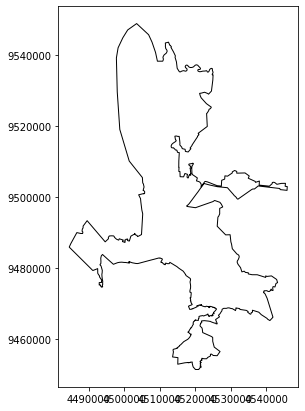

In [7]:
arch.plot(figsize=(7,7), facecolor="none", edgecolor="black")

## Нахождение замыкающего прямоугольника `Polygon`-а

In [8]:
city_geom = arch.iloc[0].geometry
rect_coords = city_geom.bounds

print(rect_coords)

xmin = rect_coords[0]
ymin = rect_coords[1]
xmax = rect_coords[2]
ymax = rect_coords[3]

(4484498.829300001, 9451420.998999998, 4545899.198399998, 9548846.765100002)


## Расчёт коеффициента искажения длинны

Расчёт коеффициента искажения длинны для данной широты

* `pi` - $\pi$
* `radCoeff` - коеффициент отношения градусов к радианам
* `earthRadius` - экваториальный радиус Земли в метрах

In [9]:
pi = math.pi
radCoeff = pi / 180
earthRadius = 6378137

### Перевод из системы `EPSG:3857` в `EPSG:4326`

Алгоритм доступен [тут](https://gist.github.com/mudpuddle/6115083)

$$
\large 
lon = \frac{x}{R} * \frac{180}{\pi}
$$

$$
\large 
lat = \left(2 * \arctan{e^{\frac{y}{R}}} - \frac{\pi}{2}\right) * \frac{180}{\pi}
$$

где:

* $R$ - экваториальный радиус Земли в метрах
* $x$ - координата `x` из `EPSG:3857`
* $y$ - координата `y` из `EPSG:3857`

Вычисляем координаты вершит прямоугольника в сситеме `EPSG:4326`

In [10]:
def convertFromWebMercator(x, y):
    #shift = pi * earthRadius;
    lon   = (x / earthRadius) / radCoeff
    lat   = (y / earthRadius) / radCoeff # y / shift * 180
    lat   = 2 * math.atan(math.exp(lat * radCoeff)) - pi / 2.0;
    lat   = lat / radCoeff
    return lon, lat

In [11]:
lon1, lat1 = convertFromWebMercator(xmin, ymin)
lon2, lat2 = convertFromWebMercator(xmax, ymin)

lon1, lat1, lon2, lat2

(40.28493839976292, 64.39746310015147, 40.836507299893995, 64.39746310015147)

### Расчёт дистанции между точками

Расчёт фактического расстояния между точками на сферической поверхности.
Алгоритм доступен [тут](https://code911.top/howto/how-to-transform-a-distance-from-degrees-to-metres).

$$
\large
\Delta lat = (lat2 - lat1) * \frac{\pi}{180}
$$

$$
\large
\Delta lon = (lon2 - lon1) * \frac{\pi}{180}
$$

$$
\large
distA =
\sin{\left(\frac{\Delta lat}{2}\right)}^2 +
\cos\left({lat1 * \frac{\pi}{180}}\right) *
\cos\left({lat2 * \frac{\pi}{180}}\right) *
\sin\left({\frac{\Delta lon}{2}}\right)^2
$$

$$
\large
D_{meter} = 2R * \arctan{\frac{\sqrt{distA}}{\sqrt{1 - distA}}}
$$

где:

* $R$ - экваториальный радиус Земли в метрах
* $lat1$ - широта левой вешины
* $lon1$ - долгота левой вешины
* $lat2$ - широта правой вешины
* $lon2$ - долгота левой вешины
* $D_{meter}$ - фактическое расстояние в метрах

In [12]:
dLat = (lat2 - lat1) * radCoeff
dLon = (lon2 - lon1) * radCoeff
dist_a = pow(math.sin(dLat / 2), 2) + \
    math.cos(lat1 * radCoeff) * math.cos(lat2 * radCoeff) * \
    pow(math.sin(dLon / 2), 2);
dist_c = 2 * math.atan2(math.sqrt(dist_a), math.sqrt(1 - dist_a))
realDistanse = earthRadius * dist_c
print ('Фактическое расстояние в километрах: {}'.format(realDistanse / 1000))

Фактическое расстояние в километрах: 26.532592869453314


### Проверяем полученное расстояние

Проверяем полученное расстояние с помощью `Yandex` карт.

![RealDistans](img/realDistanse.png)

### Расчёт формального расстояния в `EPSG:3857`

Расчёт формального расстояния между точками в `EPSG:3857`

In [13]:
merkDistanse = (xmax - xmin)
print ('Формальное расстояние в EPSG:3857: {}'.format(merkDistanse))

Формальное расстояние в EPSG:3857: 61400.369099996984


### Расчёт коеффициента искажения

In [14]:
unitCoeff = (xmax - xmin) / realDistanse
print ('Коеффициент искажения: {}'.format(unitCoeff))

Коеффициент искажения: 2.314148843352832


### Построение шестиугольников

Для [алгоритма](https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html)
расчёта вершин фигур используем константу из формулы площади шестигранника:

$$
a = \sin{\left(\frac{\pi}{3}\right)} = \frac{\sqrt{3}}{2}
$$

Площадь шестиугольника:

$$
S_{hexagon} = 3 * \sin{\left(\frac{\pi}{3}\right)} * R^2
$$

![Hexagon](img/hexagon.png)

$R$ - *большой* радиус, равен стороне шестиугольника

Далее расчёт вершин фигуры:

$A = (x, y * a)$

$B = (x + R, y * a)$

$C = (x + 1\frac{1}{2}R, (y + R) * a)$

$D = (x + R, (y + (2 * R)) * a)$

$E = (x, (y + (2 * R)) * a))$

$F = (x - (\frac{1}{2} * R), (y + R) * a)$

Где:

$x$ - начальная координата `x`

$y$ - начальная координата `y`

In [18]:
unit = 200 * unitCoeff

a = np.sin(np.pi / 3)
cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * unit)
rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, unit)

hexagons = []
for x in cols:
  for i, y in enumerate(rows):
    if (i % 2 == 0):
      x0 = x
    else:
      x0 = x + 1.5 * unit

    hexagons.append(Polygon([
      (x0, y * a),
      (x0 + unit, y * a),
      (x0 + (1.5 * unit), (y + unit) * a),
      (x0 + unit, (y + (2 * unit)) * a),
      (x0, (y + (2 * unit)) * a),
      (x0 - (0.5 * unit), (y + unit) * a),
    ]))

polygons_mesh = gpd.GeoDataFrame({'geometry': hexagons}, crs=arch.crs)
polygons_mesh['area'] = polygons_mesh.area
print(polygons_mesh.shape)
polygons_mesh.head(3)

(10980, 2)


,geometry,area
0,"POLYGON ((4484498.000 9451420.000, 4484960.830...",556537.528947
1,"POLYGON ((4485192.245 9451820.822, 4485655.074...",556537.528947
2,"POLYGON ((4484498.000 9452221.645, 4484960.830...",556537.528947


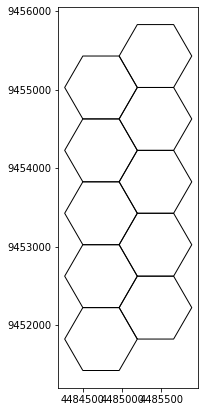

In [19]:
polygons_mesh[:10].plot(figsize=(7,7), facecolor="none", edgecolor="black")

### Ограничеваем фигуры контуром населённого пункта

In [20]:
threashold=0.5
city_geom = arch.iloc[0].geometry
print('Количество записей в начале')
print(polygons_mesh.shape[0])
city_inter_geom = polygons_mesh[polygons_mesh.intersects(city_geom)]
print('После первого фильтра')
print(city_inter_geom.shape[0])
city_values = city_inter_geom.geometry.values
polys = []
for geom in city_values:
    if ((geom.intersection(city_geom)).area / geom.area) >= threashold:
        polys.append(geom)
city_polygons = gpd.GeoDataFrame(geometry=polys, crs=arch.crs)
print('После второго фильтра')
print(city_polygons.shape[0])
city_polygons.head(3)

Количество записей в начале
10980
После первого фильтра
3770
После второго фильтра
3380


,geometry
0,"POLYGON ((4485192.245 9484688.254, 4485655.074..."
1,"POLYGON ((4485192.245 9485489.899, 4485655.074..."
2,"POLYGON ((4484498.000 9485890.721, 4484960.830..."


### Переводим в угловые координаты

In [21]:
city_polygons_wgs84 = city_polygons.to_crs('WGS84')
city_polygons_wgs84.head(3)

,geometry
0,"POLYGON ((40.29117 64.52630, 40.29533 64.52630..."
1,"POLYGON ((40.29117 64.52940, 40.29533 64.52940..."
2,"POLYGON ((40.28493 64.53094, 40.28909 64.53094..."


In [22]:
all_res = []

for _, row in city_polygons_wgs84.iterrows():
    polygon = row.geometry
    x, y = polygon.exterior.xy
    pairs = zip(x, y)
    coords = []
    for pair in pairs:
        coords.append([pair[1], pair[0]])
    obj = {}
    obj['geometry'] = [coords]
    all_res.append(obj)
    
city_polygons_dl = pd.DataFrame(all_res)
city_polygons_dl.head(3)

,geometry
0,"[[[64.5262982802965, 40.29116745586139], [64.5..."
1,"[[[64.52939535902337, 40.29116745586139], [64...."
2,"[[[64.53094376660735, 40.28493095003426], [64...."


### Интегрируем в DataLens

In [23]:
city_polygons_dl.to_csv('data/polygons_lens.csv', index=False)

### Сверяем

Фигура в `DataLens`

![BoryLens](img/boryLens.png)

Соответствие со стороной полигона на карте `Yandex`

![BoryMaps](img/boryMaps.png)